# PM-10 Regression Model

#### by Valentina Angelovska

_________________________


### About Dataset:


| Feature            | Description                                                                                 |
|--------------------|---------------------------------------------------------------------------------------------|
| **apparentTemperature** | The apparent (“feels like”) temperature in degrees Fahrenheit.                           |
| **Cloud cover**        | The percentage of sky occluded by clouds.                                                 |
| **dewPoint**           | Temperature to which air must be cooled to become saturated with water vapor.              |
| **humidity**           | The relative humidity.                                                                      |
| **precipIntensity**    | The intensity (in inches of liquid water per hour) of precipitation.                       |
| **precipProbability**  | The probability of precipitation occurring.                                                |
| **pressure**          | The sea-level air pressure in millibars.                                                    |
| **temperature**       | The air temperature in degrees Fahrenheit.                                                  |
| **time**              | The UNIX time at which this data point begins.                                              |
| **Visibility**        | The average visibility in miles.                                                            |
| **windBearing**       | The direction that the wind is coming from in degrees with true north at 0° and progressing clockwise. |
| **windSpeed**         | The speed of the wind in miles per hour.                                                    |
| **PM10**              | (Target) Atmospheric particulate matter with a diameter smaller than 10 micrometers.        |
|**no_precip**          | precipitation is any product of the condensation of atmospheric water vapor that falls from clouds due to gravitational pull|
|**rain**| 0 - no, 1-yes|
| **sleet**|0 - no, 1-yes|
|**snow**| 0 - no, 1-yes|
|**clear**| 0 - no, 1-yes|
|**drizzle**| 0 - no, 1-yes|
|**foggy**| 0 - no, 1-yes|
|**mostly cloudy**| 0 - no, 1-yes|
|**overcast**| 0 - no, 1-yes|
|**partly cloudy**| 0 - no, 1-yes|



## Load Libraries

In [83]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import random
import scipy.stats as stats
from tqdm import tqdm

# Preprocessing and hyperparameter tuning
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tpot import TPOTRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report,confusion_matrix

# Seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Read Data

In [84]:
# Load dataset
df_org = pd.read_csv('Centar_PM10.csv')

# Copy of dataset
df = df_org.copy()

df.head()

,time,PM10,apparentTemperature,cloudCover,dewPoint,humidity,precipIntensity,precipProbability,pressure,temperature,...,no precip,rain,sleet,snow,Clear,Drizzle,Foggy,Mostly Cloudy,Overcast,Partly Cloudy
0,1-1-15 0:00,30.02,9.03,0.44,5.03,0.58,0.0,0.0,1033.58,17.41,...,1,0,0,0,0,0,0,0,0,1
1,1-1-15 1:00,30.21,4.87,0.44,3.24,0.57,0.0,0.0,1033.86,15.63,...,1,0,0,0,0,0,0,0,0,1
2,1-1-15 2:00,29.40,3.62,0.44,3.24,0.62,0.0,0.0,1034.14,13.80,...,1,0,0,0,0,0,0,0,0,1
3,1-1-15 3:00,28.83,5.83,0.44,3.24,0.57,0.0,0.0,1034.42,15.63,...,1,0,0,0,0,0,0,0,0,1
4,1-1-15 4:00,27.69,5.62,0.44,2.61,0.60,0.0,0.0,1034.99,14.03,...,1,0,0,0,0,0,0,0,0,1


## Data Analysis

In [3]:
# Shape of data
df.shape

(8760, 23)

In [4]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 8760 non-null   object 
 1   PM10                 7352 non-null   float64
 2   apparentTemperature  8759 non-null   float64
 3   cloudCover           8760 non-null   float64
 4   dewPoint             8759 non-null   float64
 5   humidity             8759 non-null   float64
 6   precipIntensity      8737 non-null   float64
 7   precipProbability    8737 non-null   float64
 8   pressure             8618 non-null   float64
 9   temperature          8759 non-null   float64
 10  visibility           8759 non-null   float64
 11  windBearing          6658 non-null   float64
 12  windSpeed            8759 non-null   float64
 13  no precip            8760 non-null   int64  
 14  rain                 8760 non-null   int64  
 15  sleet                8760 non-null   i

In [5]:
# Summary Statistics of dataset
df.describe()

,PM10,apparentTemperature,cloudCover,dewPoint,humidity,precipIntensity,precipProbability,pressure,temperature,visibility,...,no precip,rain,sleet,snow,Clear,Drizzle,Foggy,Mostly Cloudy,Overcast,Partly Cloudy
count,7352.000000,8759.000000,8760.000000,8759.000000,8759.000000,8737.000000,8737.000000,8618.000000,8759.000000,8759.000000,...,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8760.000000
mean,72.802447,55.270738,0.434668,43.053717,0.665269,0.000174,0.004478,1018.756200,55.927233,5.743029,...,0.978881,0.020776,0.0,0.000342,0.309703,0.0,0.042009,0.200114,0.176712,0.270434
std,82.213323,19.135721,0.387681,12.707508,0.204420,0.001894,0.032476,8.263537,18.350654,1.312911,...,0.143788,0.142643,0.0,0.018504,0.462398,0.0,0.200621,0.400108,0.381447,0.444209
min,0.270000,0.430000,0.000000,-2.210000,0.130000,0.000000,0.000000,986.110000,4.830000,0.031000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,27.627500,39.400000,0.000000,33.580000,0.520000,0.000000,0.000000,1013.137500,40.800000,6.216000,...,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,42.680000,55.780000,0.440000,44.390000,0.700000,0.000000,0.000000,1017.860000,55.780000,6.216000,...,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,77.680000,69.180000,0.750000,54.050000,0.830000,0.000000,0.000000,1023.550833,69.180000,6.216000,...,1.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000
max,815.170000,104.870000,1.000000,69.810000,1.000000,0.097200,0.240000,1041.920000,103.810000,6.216000,...,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [6]:
# Columns with zero std
data_description = df.describe().T
data_description.loc[np.isclose(data_description['std'], 0.0, atol=1e-5)].index

Index(['sleet', 'Drizzle'], dtype='object')

In [7]:
# Missing Values
print(f'There are total {df.isna().sum().sum()} missing values\n')

df.isna().sum()

There are total 3704 missing values



time                      0
PM10                   1408
apparentTemperature       1
cloudCover                0
dewPoint                  1
humidity                  1
precipIntensity          23
precipProbability        23
pressure                142
temperature               1
visibility                1
windBearing            2102
windSpeed                 1
no precip                 0
rain                      0
sleet                     0
snow                      0
Clear                     0
Drizzle                   0
Foggy                     0
Mostly Cloudy             0
Overcast                  0
Partly Cloudy             0
dtype: int64

In [8]:
# Unique values
df.nunique().sort_values()

Drizzle                   1
sleet                     1
Partly Cloudy             2
Mostly Cloudy             2
Foggy                     2
precipProbability         2
Clear                     2
snow                      2
Overcast                  2
no precip                 2
rain                      2
precipIntensity          20
visibility               61
humidity                 86
cloudCover               92
windBearing             339
windSpeed               548
temperature            1791
apparentTemperature    2399
dewPoint               2687
pressure               4652
PM10                   5492
time                   8760
dtype: int64

In [9]:
# Duplicates
display(df.loc[df.duplicated()])

,time,PM10,apparentTemperature,cloudCover,dewPoint,humidity,precipIntensity,precipProbability,pressure,temperature,...,no precip,rain,sleet,snow,Clear,Drizzle,Foggy,Mostly Cloudy,Overcast,Partly Cloudy


## Conclusion from Data Analysis:

- **Features and Instances:**

    There are 8760 instances and 23 features.
    
- **Data Types:**

    Data types: The feature `time` is an object and should be converted to datetime (e.g., `1-1-15 0:00`).
    
- **Features type:**

    Features are already encoded (all numerical).
    
- **Standard Deviation:**    

    Two features have zero standard deviation: `sleet` and `Drizzle`. These should be dropped.
    
- **Missing Values:**

    There are a total of 3704 missing values:
  - `windBearing`: 2102
  - `PM10` (target): 1408
  - `precipIntensity`: 23
  - `precipProbability`: 23
  - `pressure`: 142
  - 6 other features with 1 missing value each.
  
- **Duplicates and Typos:**

    There are no duplicates or typos in this dataset.
    
- **Unnecessary Features:**

    In my opinion, the `time` feature should be dropped.
    
_____
    
**Dropping time, sleet and drizzle will be done in the preprocessing pipeline**

____

## Detailed Analysis of Missing Values:

In [10]:
# Missing values in whole dataset, for better understanding
missing_vals = df.isna().sum() 
missing_vals[missing_vals > 0]

PM10                   1408
apparentTemperature       1
dewPoint                  1
humidity                  1
precipIntensity          23
precipProbability        23
pressure                142
temperature               1
visibility                1
windBearing            2102
windSpeed                 1
dtype: int64

In [11]:
# How many values are nan in windbearing but not nan in windspeed?
df[(df['windBearing'].isna()) & (df['windSpeed'] > 0.0)].shape[0]

145

In [12]:
# Are there any missing values in both features
df[(df['windBearing'].isna()) & (df['windSpeed'].isna())].shape[0]

1

In [13]:
# How many values are nan in both precipIntensity and precipProbability?
df[(df['precipProbability'].isna()) & (df['precipIntensity'].isna())].shape[0]

23

In [14]:
# How many missing values in pressure will remain after dropping this nans:
df[(df['pressure'].isna()) & (~df['precipProbability'].isna()) & (~df['windBearing'].isna())].shape[0]

84

#### Conclusion:

- **WindBearing and WindSpeed:**
  - **Criteria:** I will drop rows where `WindBearing` is missing but `WindSpeed` is present, as it is not logical to have wind without a direction. Rows with missing values in both `WindBearing` and `WindSpeed` will also be dropped.
  - **Remaining Missing Values:** After this step, there will be 1,706 missing values, which is about 23% of the dataset. I will consider either removing these remaining values or imputing them with `-1`.

- **PrecipIntensity and PrecipProbability:**
  - **Criteria:** If `WindBearing` is dropped, there will be 12 missing values left in `PrecipIntensity` and `PrecipProbability`. Since both features are missing, these rows will be dropped.

- **Pressure:**
  - **Remaining Values:** After addressing the missing values in the previous steps, 70 missing values will remain in `Pressure`. Since cleaning the missing values would result in losing approximately 40% of the dataset, I will consider imputing these values rather than dropping them.

**Approach:**
I will try two approaches:
1. **Removing Missing Values:** Based on the criteria mentioned above.
2. **Imputation:** Imputing missing values in `WindBearing` with `-1` or using methods such as `KNN or RandomForest`.



## Data Cleaning

##### Dropping missing values in Target Feature

In [15]:
# Nan values in target feature -> drop
print('Percentage of missing values in target variable:', (df['PM10'].isna().sum().sum()/len(df['PM10'])*100))

Percentage of missing values in target variable: 16.073059360730593


In [85]:
# Drop this instances
df.dropna(subset=['PM10'], how = 'all', inplace=True)

# Check for nan values again
df.isna().sum()

time                      0
PM10                      0
apparentTemperature       1
cloudCover                0
dewPoint                  1
humidity                  1
precipIntensity          20
precipProbability        20
pressure                120
temperature               1
visibility                1
windBearing            1821
windSpeed                 1
no precip                 0
rain                      0
sleet                     0
snow                      0
Clear                     0
Drizzle                   0
Foggy                     0
Mostly Cloudy             0
Overcast                  0
Partly Cloudy             0
dtype: int64

##### Changing Datatype of time feature

In [86]:
df['time'] = pd.to_datetime(df['time'], format='mixed')

## Exploratory Data Analysis

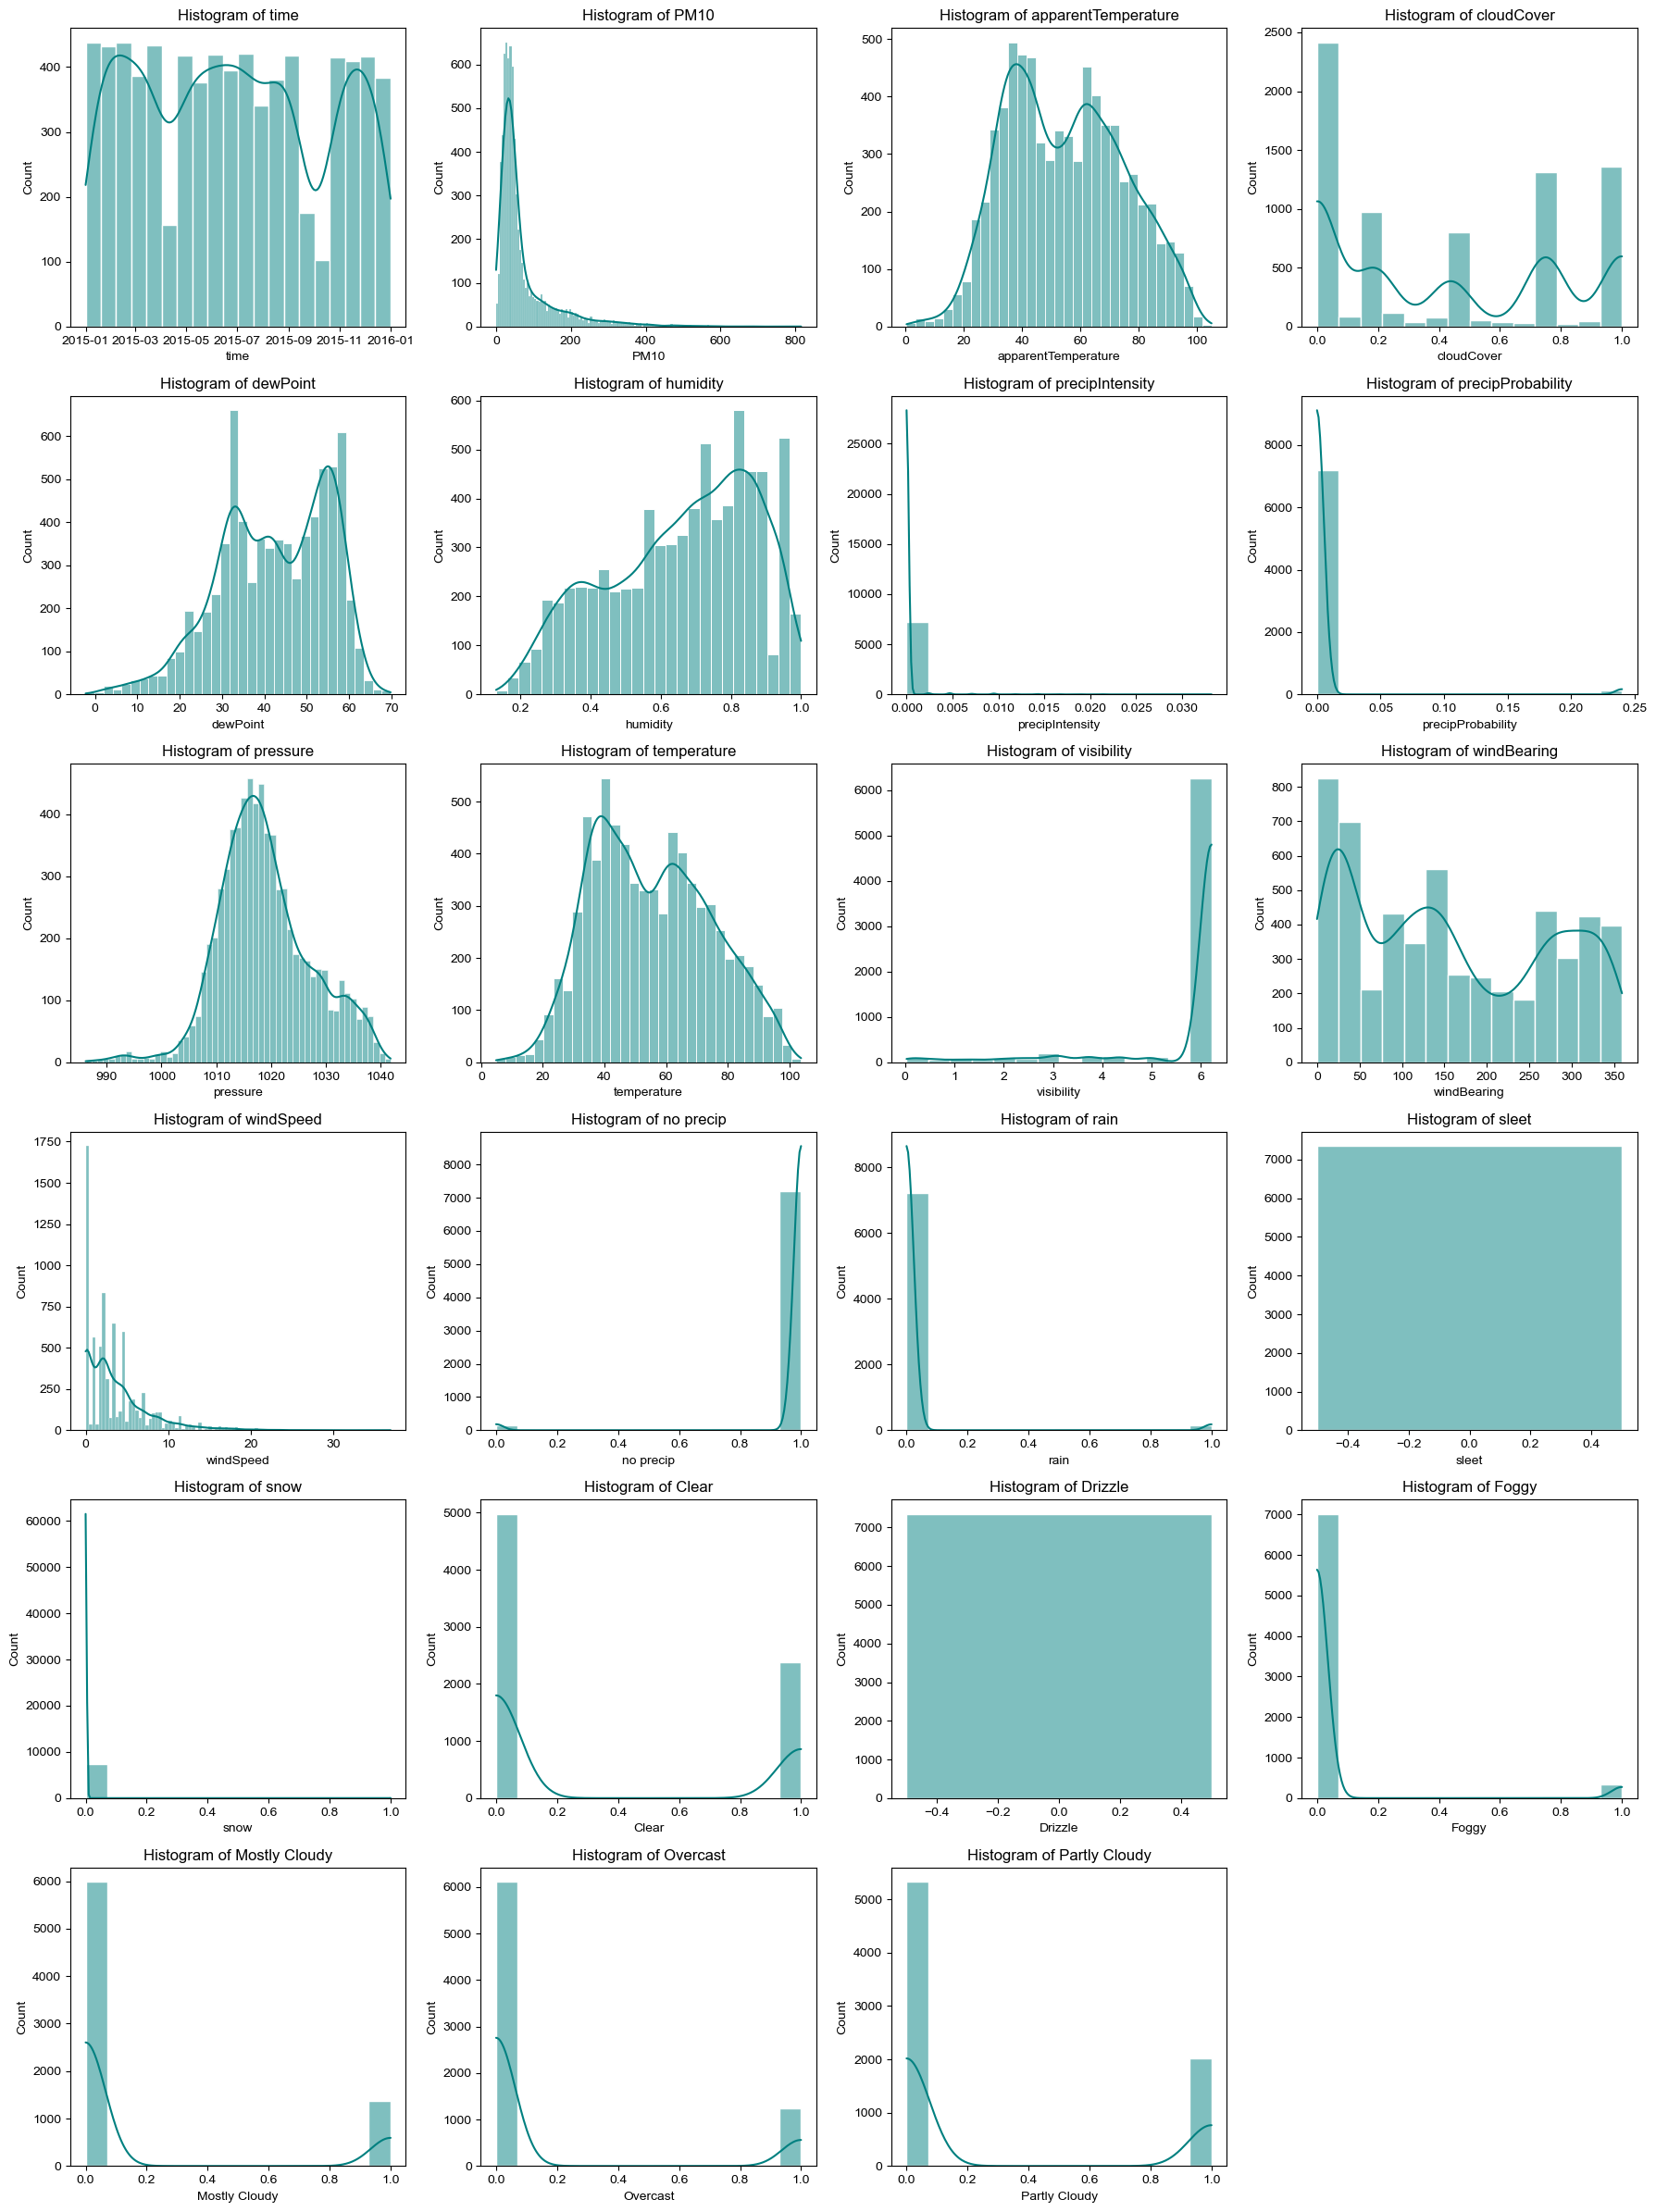

In [18]:
# Histogram plots 

# Define subplots
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(18, 24))
axs = axs.ravel()  
sns.set_style('darkgrid')

# Loop through features and plot
for i, col in enumerate(df.columns):
    sns.histplot(data=df, x=col, ax=axs[i], kde=True, color='teal')
    axs[i].set_title(f'Histogram of {col}')
    axs[i].set_xlabel(col)

# Hide any unused subplots
for j in range(len(df.columns), len(axs)):
    axs[j].axis('off')

# Show
plt.tight_layout()
plt.show()


In [19]:
# Feature Snow
df['snow'].value_counts() # this should be dropped too

snow
0    7349
1       3
Name: count, dtype: int64

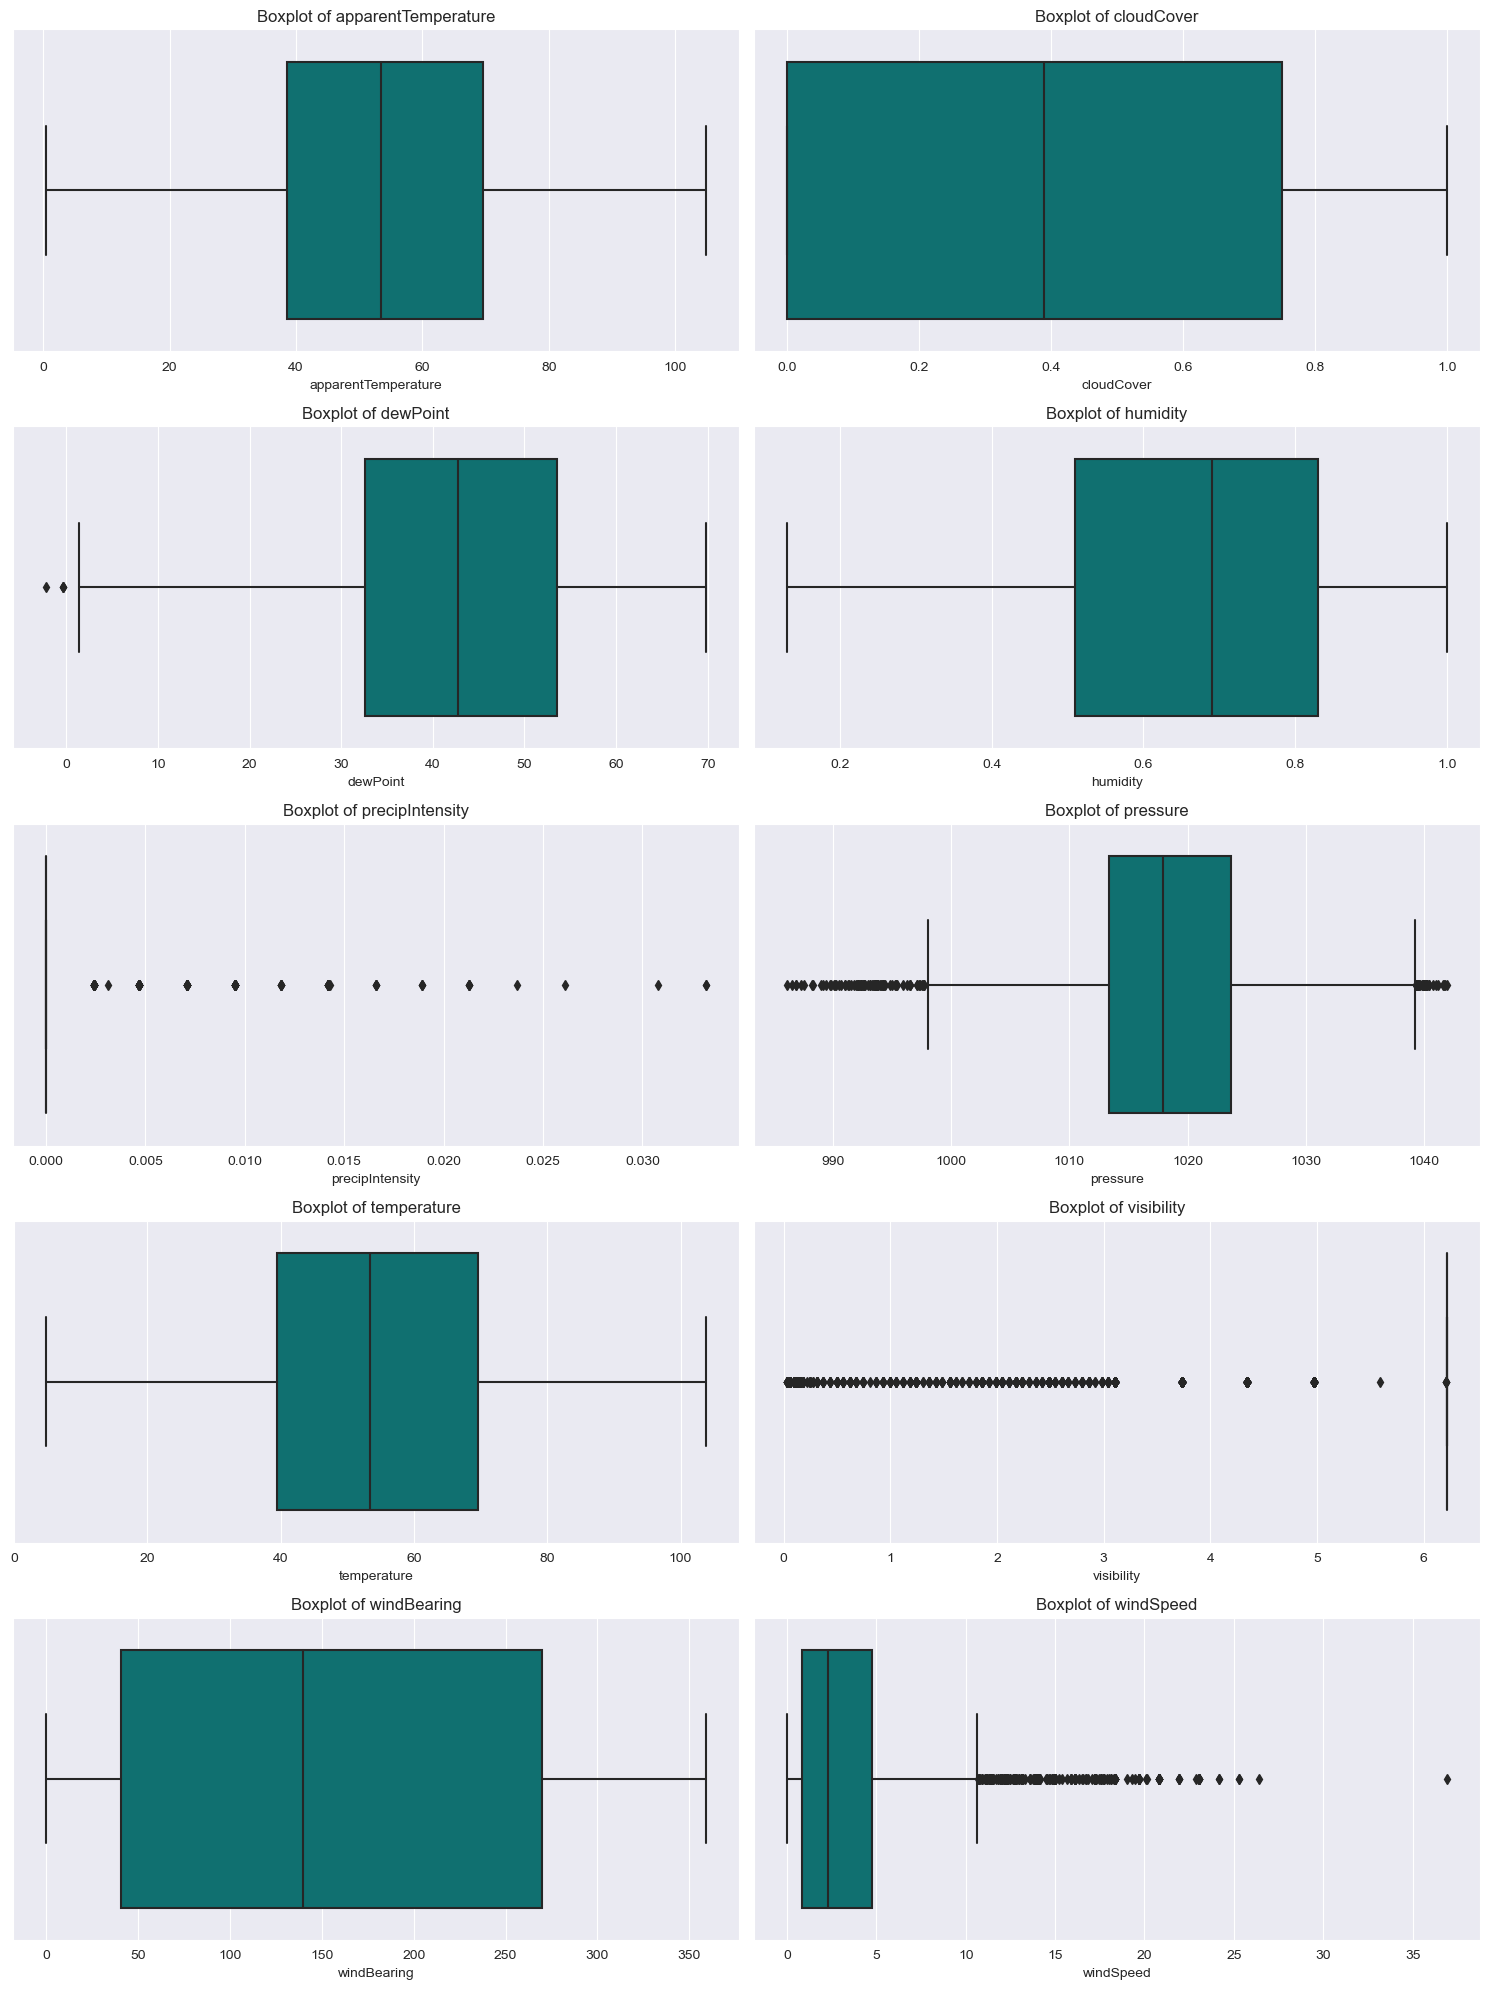

In [20]:
#Boxplots of those columns that has more than 2 values

cols = ['apparentTemperature','cloudCover', 'dewPoint','humidity', 'precipIntensity', 'pressure',
       'temperature', 'visibility','windBearing', 'windSpeed']

# Define subplots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
axs = axs.ravel()  

sns.set_style('darkgrid')

# Loop through features and plot
for i, col in enumerate(cols):
    sns.boxplot(data=df, x=col, ax=axs[i], color='teal')
    axs[i].set_title(f'Boxplot of {col}')
    axs[i].set_xlabel(col)

# Hide any unused subplots
for j in range(len(cols), len(axs)):
    axs[j].axis('off')

# Show
plt.tight_layout()
plt.show()

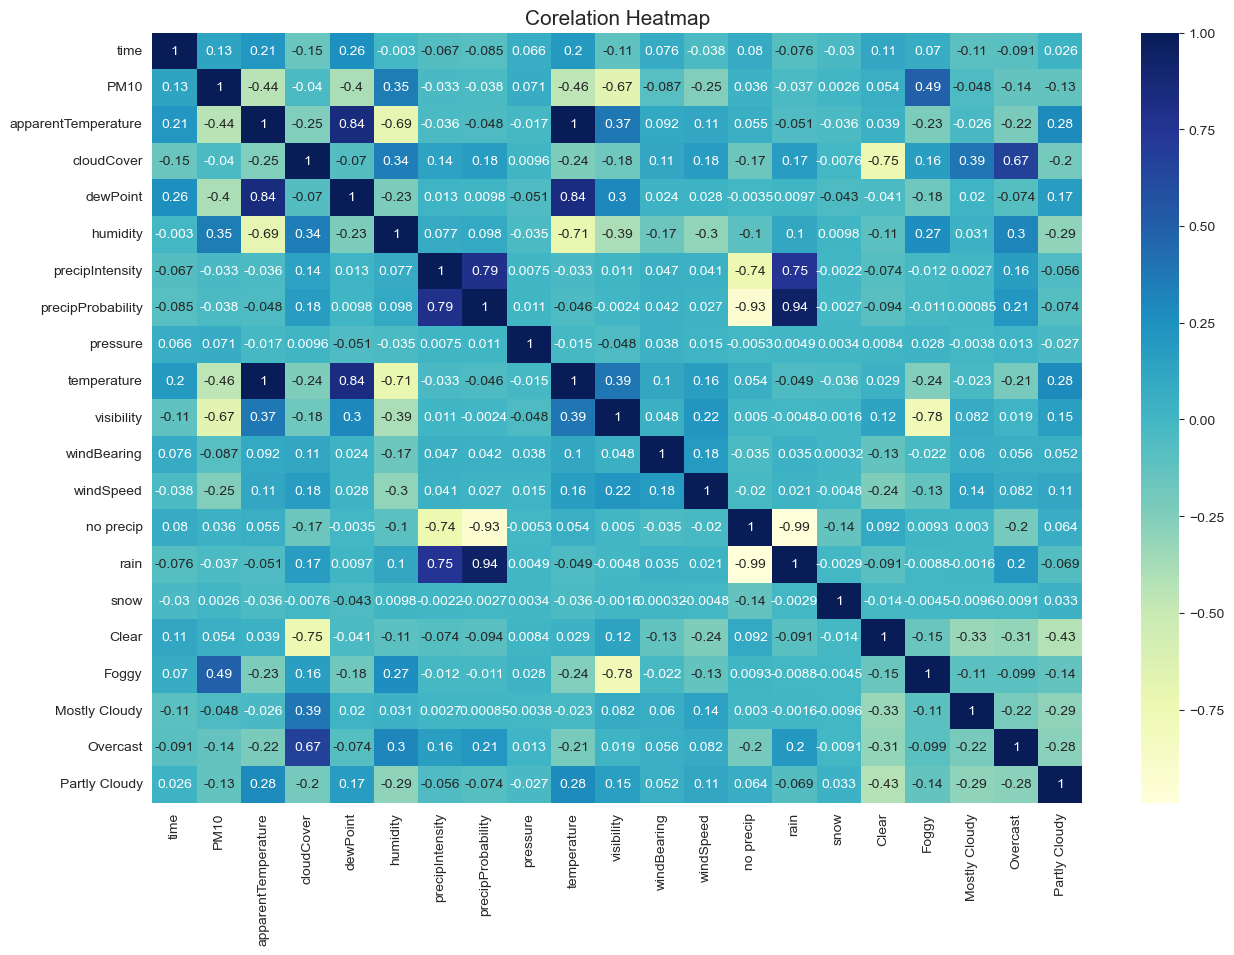

In [21]:
# Correlation Heatmap

# for the correlation heatmap i will drop sleet and drizzle because they have 0 values and fill null with 0
corr = df.drop(columns = ['sleet','Drizzle']).fillna(0).corr(numeric_only=False, method = 'pearson')

# Plot
plt.figure(figsize = (15,10))
sns.heatmap(corr, cmap = 'YlGnBu', annot=True)
plt.title('Corelation Heatmap', fontsize = 15)

# Show
plt.show()

## Conclusion from EDA:

### Histograms:

- **Time:**
  The histogram of `time` shows a somewhat uniform distribution with fluctuations, spanning from January 2015 to January 2016.

- **Target Feature (`PM10`):**
  The distribution of `PM10` is skewed with a right tail. The tail starts around 200 and extends up to 800.

- **Apparent Temperature:**
  The distribution of `apparentTemperature` is slightly normal. It resembles a bell curve but with slight deviations.

- **Cloud Cover:**
  The distribution of `cloud cover` ranges from 0 to 1, with a peak at 0. This indicates that the majority of the data points have no cloud cover, but the distribution has significant fluctuations.

- **Dew Point, Pressure, Humidity, and Temperature:**
  These features show approximately normal distributions with minor skewness. Notably, `pressure` exhibits a left skew.

- **Windspeed:**
  `windspeed` has a distribution with a long right tail, indicating occasional high wind speeds.

- **Wind Bearing:**
  The `windBearing` feature ranges from 0 to 360 degrees, with high peaks at the beginning, followed by lower values and a pattern resembling a sinusoidal wave.

- **Precipitation Intensity:**
  `precipIntensity` has values clustered around 0 and 0.1. The distribution does not appear well-defined.

- **Precipitation Probability:**
  `precipProbability` has two distinct values: 0 and 0.24, with a peak at 0.

- **Visibility:**
  `visibility` ranges from 0 to 6.5, with the highest peak around 6. The distribution shows a concentration of values at higher visibility.

- **No Precipitation:**
  The feature `no_precip` has two values: 0 and 1, with a peak at 1.

- **Weather Conditions (rain, snow, clear, foggy, mostly cloudy, overcast, partly cloudy):**
  These features also have two values: 0 and 1, with a peak at 0, indicating that most observations have these conditions absent.

### Boxplots:

- **Outliers:**
  Significant outliers were detected in `pressure` and `windspeed`.

  `precipIntensity`: The feature shows a very narrow range of values close to zero, with many outliers. The boxplot appears almost empty because most data points are clustered around very small values, indicating a highly concentrated distribution with a few extreme values.

   `visibility`: The feature has a broad range of values, but the boxplot mostly displays outliers due to the presence of a few high values compared to a concentration of lower values. The distribution is skewed, resulting in a boxplot that primarily highlights outliers rather than a well-defined box.

### Correlation Heatmap:

#### Target Feature `PM10`:

- **Highly Correlated Features:**
  - **`Foggy`**: 0.49
  - **`Humidity`**: 0.35
  - **`Visibility`**: -0.67 (negative correlation, indicating higher visibility is associated with lower PM10 levels)
  - **`Temperature`**: -0.46 (negative correlation, indicating higher temperatures are associated with lower PM10 levels)

#### Feature Correlations:

- **`ApparentTemperature`:**
  - **`DewPoint`**: 0.84 (high positive correlation, both increase or decrease together)
  - **`Temperature`**: 1.0 (identical values)
  - **`Humidity`**: -0.69 (negative correlation, as apparent temperature increases, humidity decreases)

- **`CloudCover`:**
  - **`Overcast`**: 0.67 (high positive correlation, as cloud cover increases, overcast increases)
  - **`Clear`**: -0.75 (high negative correlation, as cloud cover increases, clear conditions decrease)

- **`DewPoint`:**
  - **`Temperature`**: 0.84 (high positive correlation, as dew point increases, temperature increases)
  - **`ApparentTemperature`**: 0.84 (same correlation as with temperature)

- **`Humidity`:**
  - **`ApparentTemperature`**: -0.69 (negative correlation, as temperature increases, humidity decreases)
  - **`Temperature`**: -0.71 (negative correlation, as temperature increases, humidity decreases)

- **`PrecipIntensity`:**
  - **`PrecipProbability`**: 0.79 (high positive correlation, both increase together)
  - **`Rain`**: 0.75 (high positive correlation, both increase together)
  - **`NoPrecip`**: -0.74 (negative correlation, as precipitation intensity increases, no precipitation decreases)

- **`PrecipProbability`:**
  - **`Rain`**: 0.94 (very high positive correlation, both increase together)
  - **`NoPrecip`**: -0.93 (very high negative correlation, as probability increases, no precipitation decreases)

- **`Visibility`:**
  - **`Foggy`**: -0.78 (negative correlation, as visibility decreases, foggy conditions increase)

- **`NoPrecip`:**
  - **`PrecipIntensity`**: -0.74 (negative correlation, as no precipitation increases, precipitation intensity decreases)
  - **`PrecipProbability`**: -0.93 (very high negative correlation)
  - **`Rain`**: -0.99 (very high negative correlation, as no precipitation increases, rain decreases)

### Recommendations for Dropping Columns:

- **Highly Correlated Features:**
     - **`ApparentTemperature`** or **`Temperature`** (perfect correlation)
     - **`PrecipProbability`** or **`Rain`** (very high correlation)
     - **`NoPrecip`** (high negative correlations with other precipitation-related features)


## Data Splitting

In [87]:
# Split on dependent (y) and independent (X)
X = df.drop(columns = ['PM10'])
y = df['PM10']

# Split on train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Shape
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (5881, 22)
y_train shape: (5881,)
X_test shape: (1471, 22)
y_test shape: (1471,)


## Data Preprocessing

In [23]:
# Categorical and Numerical features
columns_to_drop = ['no precip', 'rain','sleet','snow','Drizzle','temperature','time']
cat_cols = ['Clear', 'Foggy', 'Mostly Cloudy', 'Overcast', 'Partly Cloudy']
num_cols = list(set(X.columns) - set(cat_cols) - set(columns_to_drop))

In [24]:
# Before pipeline definition i will drop Nan values in both train and test set (this can be done in pipe too)

# train set
indices_train = X_train[['windBearing','precipIntensity','precipProbability']].isnull().any(axis=1)

# drop
X_train = X_train[~indices_train].reset_index(drop=True)
y_train = y_train[~indices_train].reset_index(drop=True)


# test set
indices_test = X_test[['windBearing','precipIntensity','precipProbability']].isnull().any(axis=1)

# drop
X_test = X_test[~indices_test].reset_index(drop=True)
y_test = y_test[~indices_test].reset_index(drop=True)

In [25]:
# Defining Pipelines
cat_pipe = Pipeline(steps = [('encoder', OrdinalEncoder()) #if the features were not encoded
                            ])

num_pipe = Pipeline(steps=[
                ('impute', KNNImputer(n_neighbors=5)),
                ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
                ('categorical',cat_pipe,cat_cols),
                ('numerical', num_pipe,num_cols)],
                 remainder='drop'
                )

## Model Training 

#### Baseline Regressors

In [26]:
# Baseline Regressor with default parameters

# Define Pipes
dummy = Pipeline(steps = [('preprocess', preprocessor),
                               ('reg', DummyRegressor(strategy="mean"))])
lin = Pipeline(steps = [('preprocess', preprocessor),
                               ('reg', LinearRegression())])
dt = Pipeline(steps = [('preprocess', preprocessor),
                               ('reg', DecisionTreeRegressor(random_state=SEED))])
rf = Pipeline(steps = [('preprocess', preprocessor),
                               ('reg', RandomForestRegressor(random_state=SEED))])

# Fit
dummy.fit(X_train, y_train)
lin.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Predict
y_dm = dummy.predict(X_test)
y_lin = lin.predict(X_test)
y_dt = dt.predict(X_test)
y_rf = rf.predict(X_test)

# Evaluate

#dummy
mae_dm_test = mean_absolute_error(y_test, y_dm)
rmse_dm_test = np.sqrt(mean_squared_error(y_test, y_dm))
r2_dm_test = r2_score(y_test, y_dm)

mae_dm_train = mean_absolute_error(y_train, dummy.predict(X_train))
rmse_dm_train = np.sqrt(mean_squared_error(y_train, dummy.predict(X_train)))
r2_dm_train = r2_score(y_train, dummy.predict(X_train))

# Linear
mae_lin_test = mean_absolute_error(y_test, y_lin)
rmse_lin_test = np.sqrt(mean_squared_error(y_test, y_lin))
r2_lin_test = r2_score(y_test, y_lin)

mae_lin_train = mean_absolute_error(y_train, lin.predict(X_train))
rmse_dt_train = np.sqrt(mean_squared_error(y_train, lin.predict(X_train)))
r2_lin_train = r2_score(y_train, lin.predict(X_train))

# DT
mae_dt_test = mean_absolute_error(y_test, y_dt)
rmse_dt_test = np.sqrt(mean_squared_error(y_test, y_dt))
r2_dt_test = r2_score(y_test, y_dt)

mae_dt_train = mean_absolute_error(y_train, dt.predict(X_train))
rmse_lin_train = np.sqrt(mean_squared_error(y_train, dt.predict(X_train)))
r2_dt_train = r2_score(y_train, dt.predict(X_train))

# RF
mae_rf_test = mean_absolute_error(y_test, y_rf)
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_rf))
r2_rf_test = r2_score(y_test, y_rf)

mae_rf_train = mean_absolute_error(y_train, rf.predict(X_train))
rmse_rf_train = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
r2_rf_train = r2_score(y_train, rf.predict(X_train))

# Create Dataframe from results
data = {'Metric': ['MAE_Test', 'RMSE_Test', 'R2_Test','MAE_Train', 'RMSE_Train', 'R2_Train'],
        'Dummy': [mae_dm_test, rmse_dm_test, r2_dm_test, mae_dm_train, rmse_dm_train, r2_dm_train],
        'Linear': [mae_lin_test, rmse_lin_test, r2_lin_test, mae_lin_train, mae_lin_train, r2_lin_train],
        'DecisionTree': [mae_dt_test, rmse_dt_test, r2_dt_test, mae_dt_train, rmse_dt_train, r2_dt_train],
        'RandomForest': [mae_rf_test, rmse_rf_test, r2_rf_test, mae_rf_train, rmse_rf_train, r2_rf_train] 
       }

# Results
report_base = pd.DataFrame(data, columns = ['Metric', 'Dummy', 'Linear', 'DecisionTree', 'RandomForest'])
report_base

,Metric,Dummy,Linear,DecisionTree,RandomForest
0,MAE_Test,47.510948,31.813334,28.395469,21.423967
1,RMSE_Test,76.505277,51.163941,54.095671,37.016209
2,R2_Test,-0.000177,0.552676,0.499944,0.765859
3,MAE_Train,46.053698,31.271256,0.000652,8.287390
4,RMSE_Train,74.200385,31.271256,50.982111,15.681446
5,R2_Train,0.000000,0.527912,1.000000,0.955336


### Visualize the Predictions/Errors

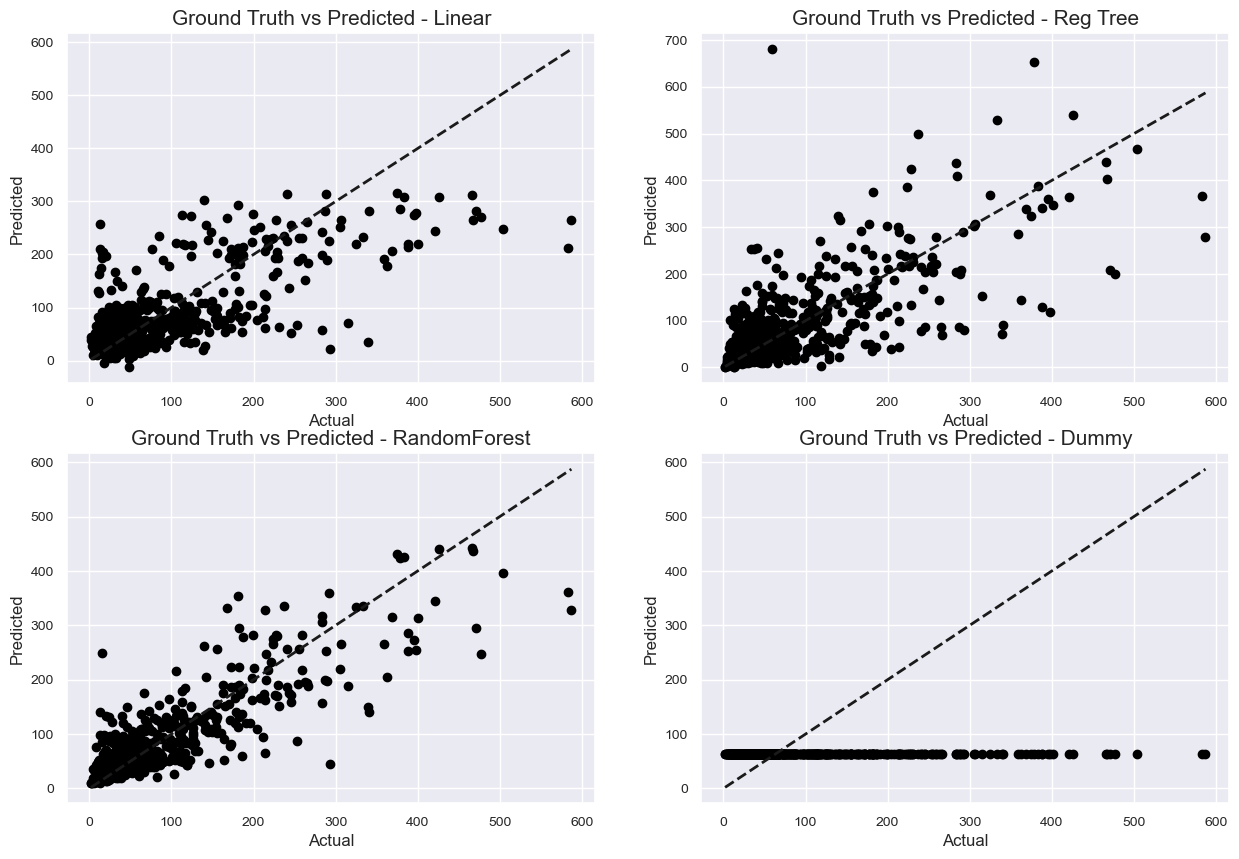

In [53]:
# Define subplots
sns.set(font_scale=2.5)
fig, ax = plt.subplots(2, 2, figsize=(15,10))

#Linear model
ax[0][0].scatter(y_test, y_lin, color='black')
ax[0][0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax[0][0].set_title('Ground Truth vs Predicted - Linear', fontsize = 15)
ax[0][0].set_xlabel('Actual', fontsize=12)
ax[0][0].set_ylabel('Predicted', fontsize=12)
ax[0][0].tick_params(axis='x', labelsize=10)  
ax[0][0].tick_params(axis='y', labelsize=10)

# Decision Tree
ax[0][1].scatter(y_test, y_dt, color='black')
ax[0][1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax[0][1].set_title('Ground Truth vs Predicted - Reg Tree', fontsize = 15)
ax[0][1].set_xlabel('Actual', fontsize=12)
ax[0][1].set_ylabel('Predicted', fontsize=12)
ax[0][1].tick_params(axis='x', labelsize=10) 
ax[0][1].tick_params(axis='y', labelsize=10)

# RandomForest
ax[1][0].scatter(y_test, y_rf, color='black')
ax[1][0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax[1][0].set_title('Ground Truth vs Predicted - RandomForest', fontsize = 15)
ax[1][0].set_xlabel('Actual', fontsize=12)
ax[1][0].set_ylabel('Predicted', fontsize=12)
ax[1][0].tick_params(axis='x', labelsize=10)  
ax[1][0].tick_params(axis='y', labelsize=10)

# Dummy
ax[1][1].scatter(y_test, y_dm, color='black')
ax[1][1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax[1][1].set_title('Ground Truth vs Predicted - Dummy', fontsize = 15)
ax[1][1].set_xlabel('Actual', fontsize=12)
ax[1][1].set_ylabel('Predicted', fontsize=12)
ax[1][1].tick_params(axis='x', labelsize=10)  
ax[1][1].tick_params(axis='y', labelsize=10)

#### GridSearchCV

In [70]:
def model_loop(X, y, reg, grid_params):
    
    print('Currently fitting model:', reg)
    
    # Define bins
    y_binned = pd.qcut(y,q=3, labels=False, duplicates='drop')
    
    # Define SKF
    skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=SEED).split(X,y_binned)

    # Define Pipe
    pipeline= Pipeline(steps = [('preprocess', preprocessor),
                                ('reg', reg)])
    

    # Define RandomizedSearch
    model = GridSearchCV(estimator=pipeline,
                         param_grid = grid_params,
                         cv = skf,
                         scoring='r2',
                         refit=True,
                         n_jobs=-1,
                         verbose=2) 
    model.fit(X,y)
    
    # evaluate
    print('Best Parameters:', model.best_params_)
    print('\nBest Score:', model.best_score_)
    
    return reg,model.best_score_

In [71]:
# Define parameters
param_dicts = [
    {'reg': RandomForestRegressor(),
        'name': 'RF',
        'grid_dict': {'reg__criterion': ['absolute_error', 'squared_error'],
            'reg__max_depth': [3,5],
            'reg__min_samples_leaf': [2,3],
            'reg__min_samples_split': [5,7],
            'reg__n_estimators': [50, 100],
            'reg__random_state': [SEED]}
    },

    {'reg': SGDRegressor(),
        'name': 'sgd',
        'grid_dict': {
            'reg__alpha': [0.001,0.005,0.01, 0.1],
            'reg__penalty': ['l2', 'l1', 'elasticnet'],
            'reg__random_state': [SEED]}
    },
    
    {'reg': KNeighborsRegressor(),
      'name': 'KNN',
       'grid_dict': {
           'reg__n_neighbors':[3,5,8,9,10]}
      }
        
    ]

In [72]:
# Loop through each model and find best parameters
best_models=[]

for el in tqdm(param_dicts):
    print(el['name'])
    model_name, best_score = model_loop(X_train, y_train, el['reg'], el['grid_dict'])
    best_models.append([model_name,best_score])

  0%|          | 0/3 [00:00<?, ?it/s]

RF
Currently fitting model: RandomForestRegressor()
Fitting 5 folds for each of 32 candidates, totalling 160 fits


 33%|███▎      | 1/3 [09:40<19:21, 580.51s/it]

Best Parameters: {'reg__criterion': 'squared_error', 'reg__max_depth': 5, 'reg__min_samples_leaf': 3, 'reg__min_samples_split': 5, 'reg__n_estimators': 100, 'reg__random_state': 42}

Best Score: 0.6385816906644561
sgd
Currently fitting model: SGDRegressor()
Fitting 5 folds for each of 12 candidates, totalling 60 fits


 67%|██████▋   | 2/3 [09:44<04:01, 241.32s/it]

Best Parameters: {'reg__alpha': 0.001, 'reg__penalty': 'l1', 'reg__random_state': 42}

Best Score: 0.514789816694037
KNN
Currently fitting model: KNeighborsRegressor()
Fitting 5 folds for each of 5 candidates, totalling 25 fits


100%|██████████| 3/3 [09:45<00:00, 195.14s/it]

Best Parameters: {'reg__n_neighbors': 9}

Best Score: 0.6098017732167893


In [73]:
report_grid = pd.DataFrame(best_models, columns=['Model','Score'])  
report_grid

,Model,Score
0,RandomForestRegressor(),0.638582
1,SGDRegressor(),0.514790
2,KNeighborsRegressor(),0.609802


In [81]:
# Best model scoring
rf_grid= Pipeline(steps = [('preprocess', preprocessor),
                      ('reg', RandomForestRegressor(criterion='squared_error',n_estimators = 50, max_depth = 5,
                                                    min_samples_split=5, min_samples_leaf=2, random_state=SEED))])
# Fit
rf_grid.fit(X_train,y_train)

# Predict
rf_predict= rf_grid.predict(X_test)

# Score
print('Evaluation for RF:')
print('R2 score test:', np.round(r2_score(y_test,rf_predict),3))
print('R2 score train:', np.round(r2_score(y_train,rf_grid.predict(X_train)),3))
print('MAE test:', np.round(mean_absolute_error(y_test,rf_predict),3))
print('MAE train:', np.round(mean_absolute_error(y_train,rf_grid.predict(X_train)),3))
print('RMSE test:', np.round(np.sqrt(mean_squared_error(y_test,rf_predict)),3))
print('RMSE train:', np.round(np.sqrt(mean_squared_error(y_train,rf_grid.predict(X_train))),3))

# KNN scoring 
knn_grid= Pipeline(steps = [('preprocess', preprocessor),
                            ('reg', KNeighborsRegressor(n_neighbors = 9))])
# Fit
knn_grid.fit(X_train,y_train)

# Predict
knn_predict= knn_grid.predict(X_test)

# Score
print('\nEvaluation for KNN:')
print('R2 score test:', np.round(r2_score(y_test,knn_predict),3))
print('R2 score train:', np.round(r2_score(y_train,knn_grid.predict(X_train)),3))
print('MAE test:', np.round(mean_absolute_error(y_test,knn_predict),3))
print('MAE train:', np.round(mean_absolute_error(y_train,knn_grid.predict(X_train)),3))
print('RMSE test:', np.round(np.sqrt(mean_squared_error(y_test,knn_predict)),3))
print('RMSE train:', np.round(np.sqrt(mean_squared_error(y_train,knn_grid.predict(X_train))),3))

Evaluation for RF:
R2 score test: 0.706
R2 score train: 0.704
MAE test: 25.116
MAE train: 24.369
RMSE test: 41.505
RMSE train: 40.372

Evaluation for KNN:
R2 score test: 0.692
R2 score train: 0.69
MAE test: 24.298
MAE train: 22.354
RMSE test: 42.487
RMSE train: 41.282


### Visualize the Predictions/Errors

[Text(0.5, 0, 'Actual'), Text(0, 0.5, 'Predicted')]

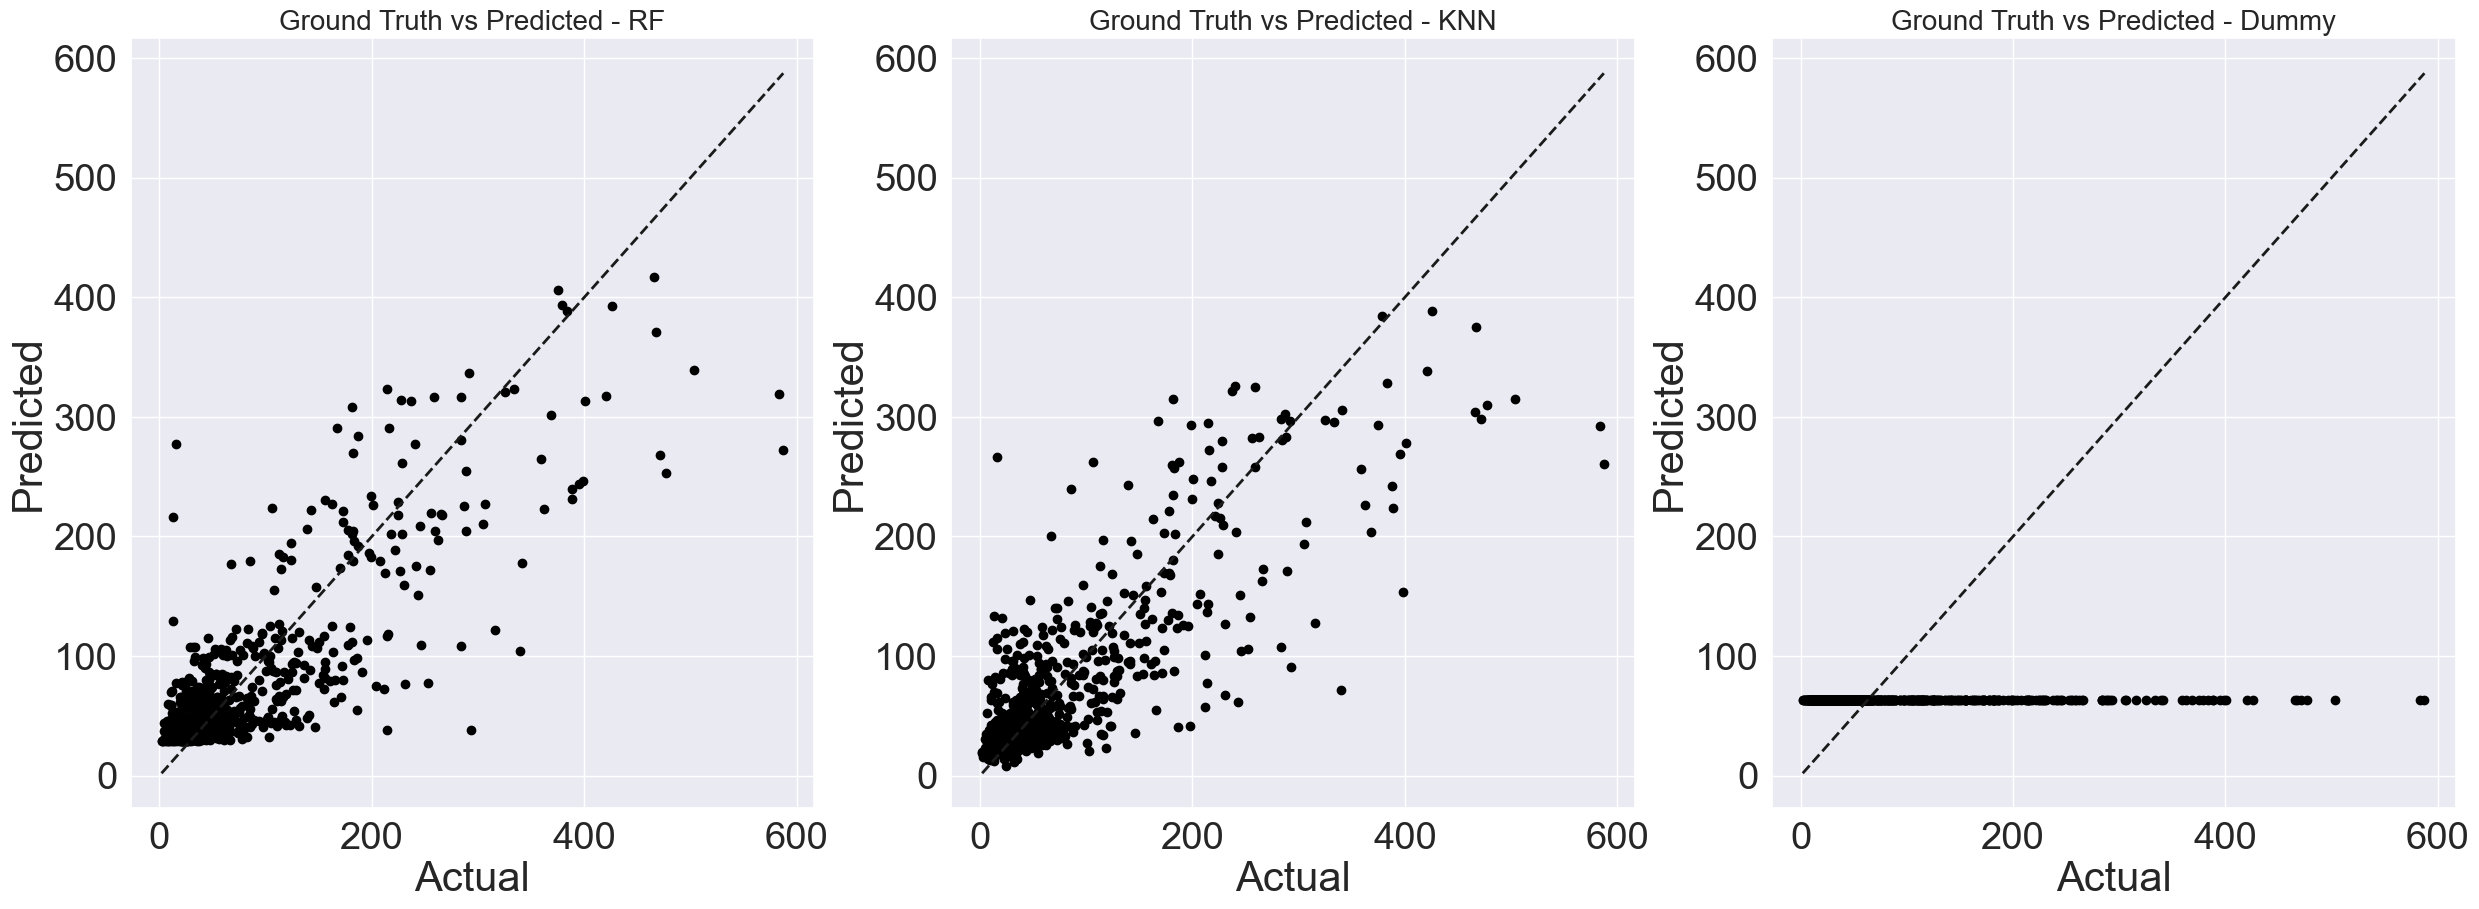

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

# RF
ax1.scatter(y_test, rf_predict, color='black')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax1.set_title('Ground Truth vs Predicted - RF', fontsize = 20)
ax1.set(xlabel='Actual', ylabel='Predicted')

# KNN
ax2.scatter(y_test, knn_predict, color='black')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax2.set_title('Ground Truth vs Predicted - KNN', fontsize = 20)
ax2.set(xlabel='Actual', ylabel='Predicted')

# Dummy
ax3.scatter(y_test, y_dm, color='black')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax3.set_title('Ground Truth vs Predicted - Dummy', fontsize = 20)
ax3.set(xlabel='Actual', ylabel='Predicted')

## Conclusion:

For this dataset, I removed 40% of the missing values and imputed the remaining missing values in the `pressure` feature. This decision was made because more than 40% of the values were missing in the `windBearing` feature. The model was trained, and hyperparameter optimization was attempted using RandomizedSearchCV, GridSearchCV, and TPOT. All these methods resulted in nearly the same results, leading me to decide on GridSearchCV for the final model.

### Model Evaluation

- **Default Evaluated Model**:
  - **RandomForest Regressor**:
    - **Test R² Score**: 76.6%
    - **Train R² Score**: 95.5%
    - The model exhibited overfitting, as indicated by the significant difference between the training and test scores.

- **GridSearch Optimization**:
  - **Models Used**: RandomForest, KNN, and SGD Regressor
  - The highest R² score was achieved using the RandomForest model.
       - **Test R² Score**: 70.6%
       - **Train R² Score**: 70.4%
       - The model perform similarly on both the training and test datasets, suggesting that is generalizing well.

### Recommendations for Improvement

While the obtained results are not as good as hoped, there is always room for improvement. Here are some recommendations:

1. **Feature Engineering**: 
   - Create new features that could help the model capture more information from the data.

2. **Advanced Imputation Techniques**:
   - Use more sophisticated imputation techniques, such as predictive modeling-based imputation, to handle missing values.

4. **Model Complexity**:
   - Experiment with more complex models like Gradient Boosting Machines (GBM) or Neural Networks, which might capture non-linear relationships better.

5. **Hyperparameter Tuning**:
   - Perform a more extensive hyperparameter search to find the optimal settings for the models. Further optimize hyperparameters using more exhaustive searches or advanced techniques like Bayesian Optimization.
   
6. **Ensemble Methods**: 
   - Consider combining multiple models to form an ensemble for potentially better performance.


By implementing these improvements, the model's performance may increase, leading to better predictions and reduced overfitting.
